# CS5483 Data Warehousing and Data Mining Project

*Author: Group1*

## Table of Contents
* [Part1. Introduction](#chapter1)
* [Part2. Data Process and Description](#chapter2)
    * [2.1 Pre-processing](#section_2_1)
    * [2.2 Preliminary data analysis](#section_2_2)
    * [2.3 Variable correlation analysis](#section_2_3)
* [Part3. Model establishment and algorithm analysis ](#chapter3)
    * [3.1 KNN](#section_3_1)
    * [3.2 Random Forest](#section_3_2)
    * [3.3 Principal Componet Analysis](#section_3_3)
* [Part4. Conclusions from Explatory Data Analysis](#chapter4)
    * [4.1 Conclusions from Explatory Data Analysis](#section_4_1)
    * [4.2 KNN Analysis](#section_4_2)
    * [4.3 Random Forest Analysis](#section_4_3)

# Part 1. Introduction <a id="chapter1"></a>

- According to the CDC, heart disease is one of the leading causes of death for people of most races in the US (African Americans, American Indians and Alaska Natives, and white people). About half of all Americans (47%) have at least 1 of 3 key risk factors for heart disease: high blood pressure, high cholesterol, and smoking. Other key indicators include diabetic status, obesity (high BMI), not getting enough physical activity or drinking too much alcohol. Detecting and preventing the factors that have the greatest impact on heart disease is very important in healthcare. Computational developments, in turn, allow the application of machine learning methods to detect "patterns" from the data that can predict a patient's condition.

- The dataset come from the CDC and is a major part of the Behavioral Risk Factor Surveillance System (BRFSS), which conducts annual telephone surveys to gather data on the health status of U.S. residents. As the CDC describes: "Established in 1984 with 15 states, BRFSS now collects data in all 50 states as well as the District of Columbia and three U.S. territories. BRFSS completes more than 400,000 adult interviews each year, making it the largest continuously conducted health survey system in the world.". The most recent dataset (as of February 15, 2022) includes data from 2020. It consists of 401,958 rows and 279 columns. The vast majority of columns are questions asked to respondents about their health status.

# Part 2.Data Process and Description <a id="chapter2"></a>

##  Import dependences

In [1]:
# import package
import math
import os

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, fcluster, leaders, linkage, ward
from scipy.sparse import csr_matrix
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler

In [2]:
%matplotlib inline

In [3]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

sns.set_style("white")
%store -r

## 2.1 Pre-processing  <a id="section_2_1"></a>

In [4]:
# import source data
heart_df = pd.read_csv("./heart_2020_cleaned.csv")

FileNotFoundError: [Errno 2] No such file or directory: './heart_2020_cleaned.csv'

In [5]:
# De duplication, de unmaned, de Nan
# When keep = 'first', keep the sample when the label appears for the first time, and discard all repeated labels.
# When inplace = false, return the dataframe after removing duplicates, and the original dataframe will not be changed.
# dropna(axis=1,how='all'). Dropna (axis = 0, how ='Any ') deletes columns that are all Nan and any rows with Nan
def cleanData(data):
    cleaned_data = (
        data.drop_duplicates(keep="first", inplace=False)
        .loc[:, ~data.columns.str.contains("^Unnamed")]
        .dropna(axis=1, how="all")
        .dropna(axis=0, how="any")
    )
    return cleaned_data

In [6]:
# clean data
heart_df = cleanData(heart_df)

NameError: name 'heart_df' is not defined

## 2.2 Preliminary data analysis  <a id="section_2_2"></a>

In [7]:
# Dataset's information
heart_df.info()

NameError: name 'heart_df' is not defined

In [8]:
def countp(var):

    # Plot
    fig, ax = plt.subplots(figsize=(20, 10), dpi=200)
    sns.countplot(data=heart_df, x=var, palette="Set1")

    # Personalization
    plt.title("Heart Disease", fontsize=18)
    plt.xticks(rotation=0, fontsize=16, horizontalalignment="center", alpha=0.7)
    plt.yticks(fontsize=14, alpha=0.7)
    plt.grid(axis="both", alpha=0.3)
    ax.set_xlabel("", fontsize=16)
    ax.set_ylabel("Count", fontsize=16)

    plt.gca().spines["top"].set_alpha(0.0)
    plt.gca().spines["bottom"].set_alpha(0.3)
    plt.gca().spines["right"].set_alpha(0.0)
    plt.gca().spines["left"].set_alpha(0.3)

    return plt.show()

NameError: name 'heart_df' is not defined

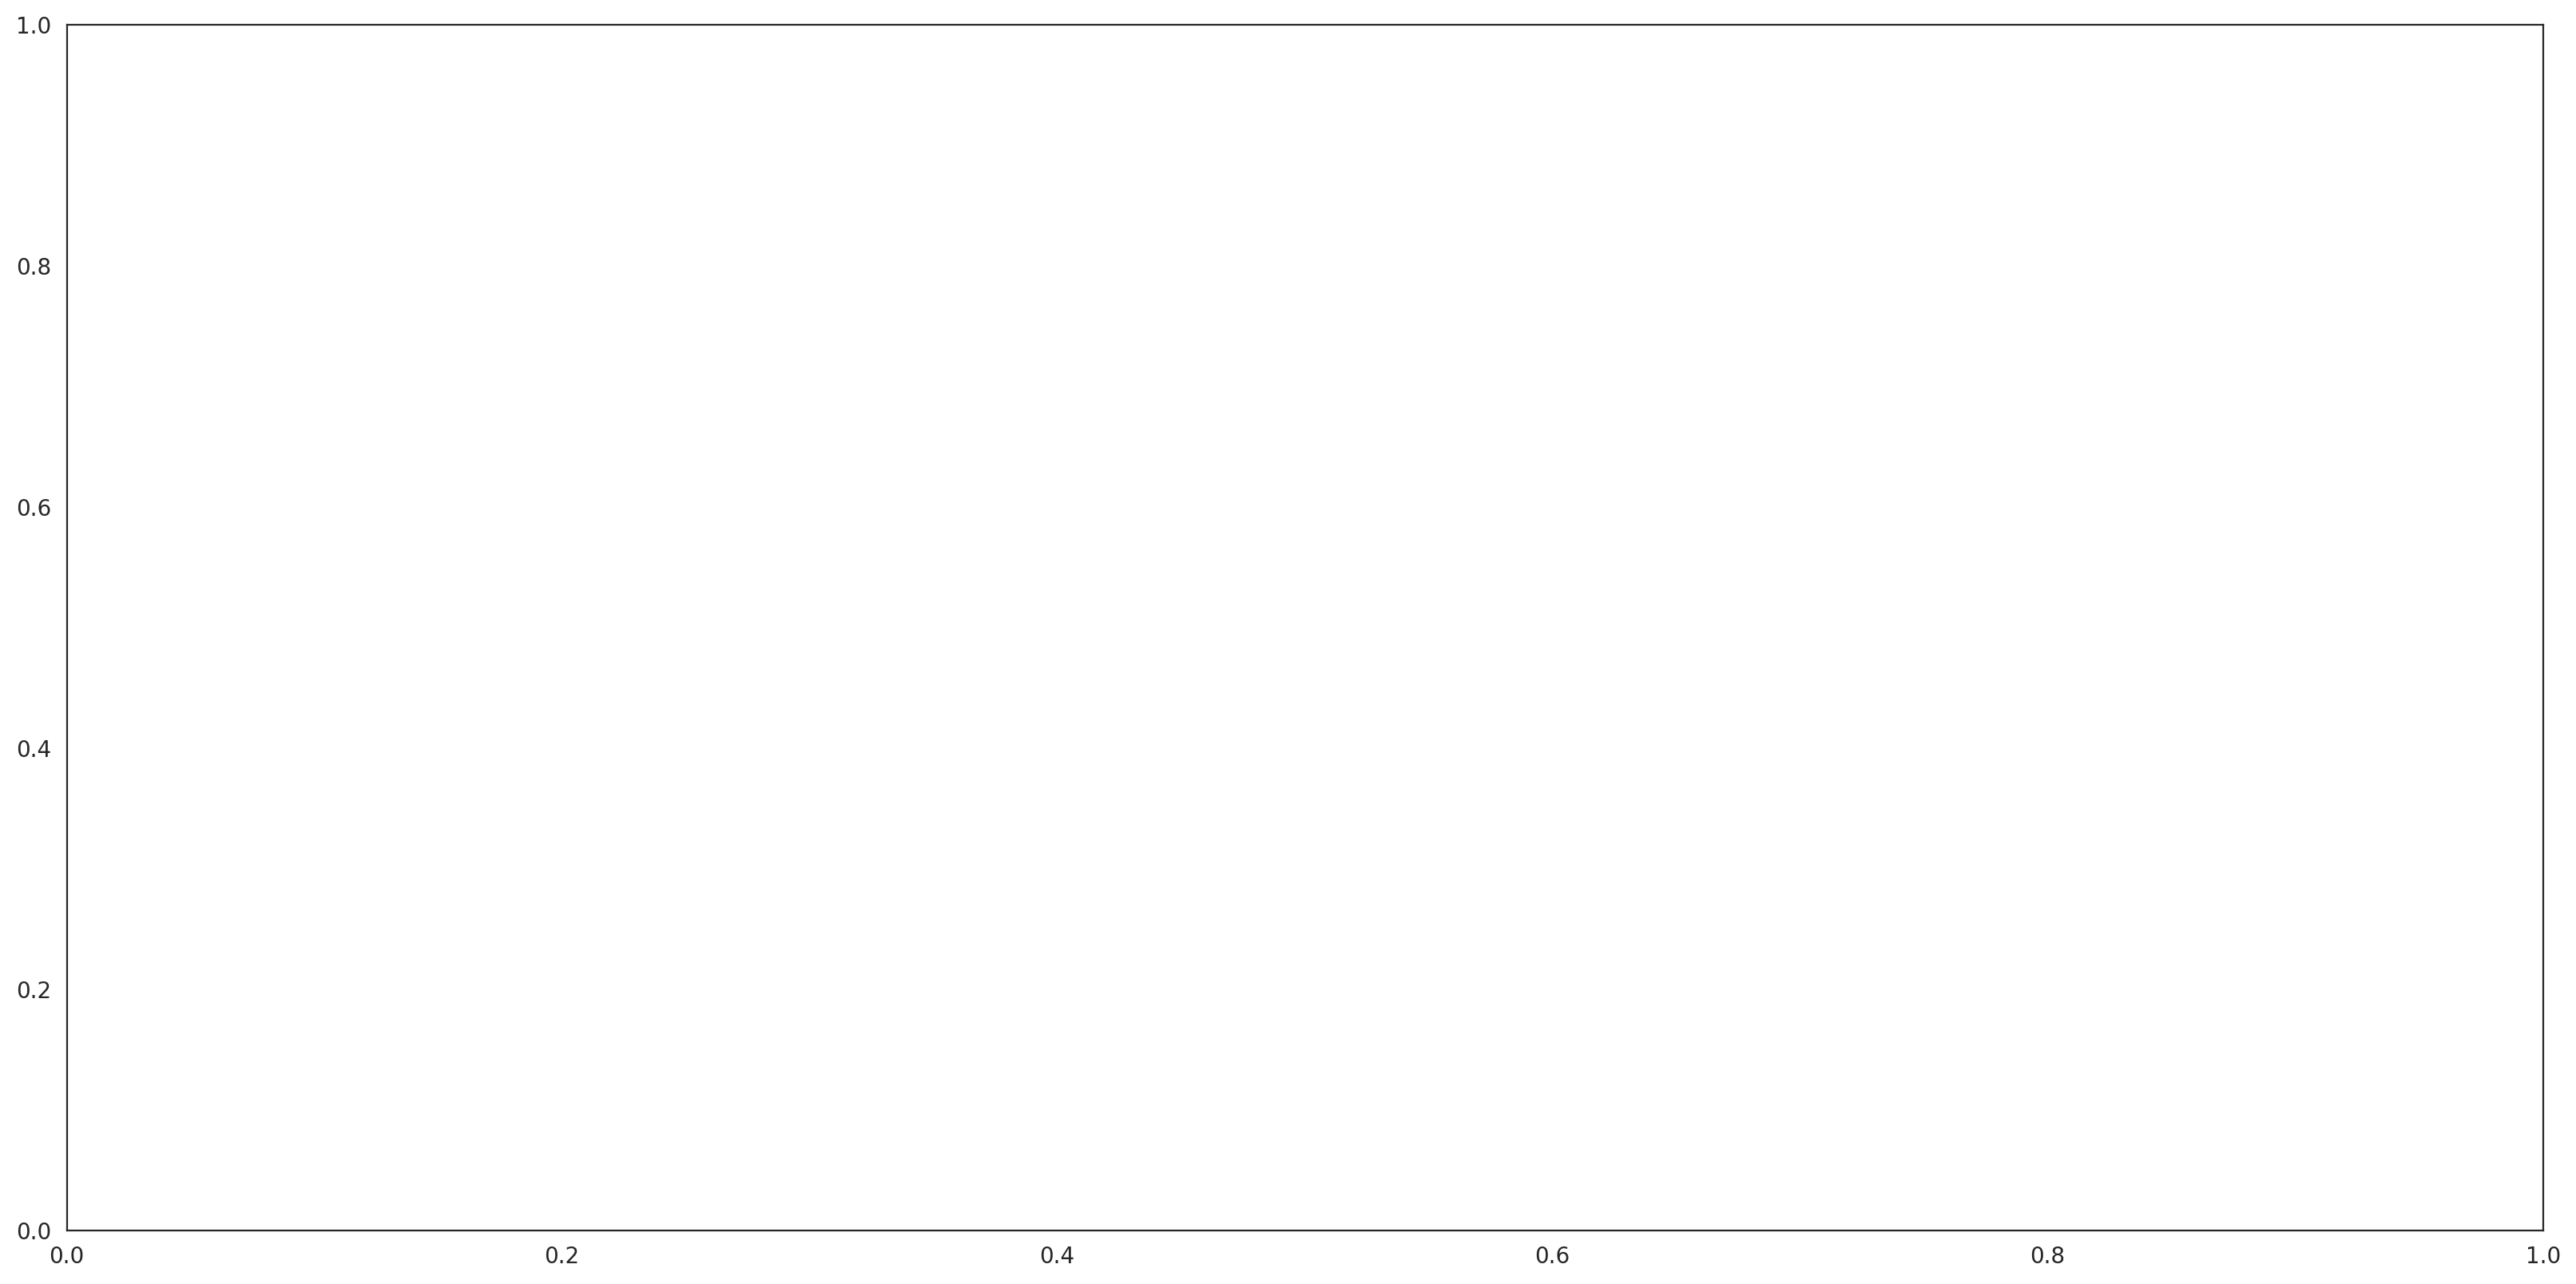

In [9]:
# Countplot for the variable "HeartDisease"
countp(var="HeartDisease")

The figure above shows a significant imbalance between people with and without heart disease in the data set. Therefore, the EDA of classified data will use standardized values.

In [10]:
def barp(var, order=None):

    # Plot
    data_normalized = (
        heart_df.groupby(f"{var}")["HeartDisease"]
        .value_counts(normalize=True)
        .rename("Percentage")
        .mul(100)
        .reset_index()
        .sort_values(f"{var}")
    )

    fig, ax = plt.subplots(figsize=(20, 10), dpi=200)
    sns.barplot(
        x=var,
        y="Percentage",
        hue="HeartDisease",
        data=data_normalized,
        order=order,
        palette="Set1",
    )

    # Personalization
    plt.xticks(rotation=0, fontsize=16, horizontalalignment="center", alpha=0.7)
    plt.yticks(fontsize=14, alpha=0.7)
    plt.grid(axis="both", alpha=0.3)
    plt.title("Heart Disease", fontsize=18)
    ax.set_xlabel(f"{var}", fontsize=18)
    ax.set_ylabel("Percentage (%)", fontsize=18)
    ax.legend(frameon=False, ncol=len(heart_df.columns), fontsize="xx-large")

    plt.gca().spines["top"].set_alpha(0.0)
    plt.gca().spines["bottom"].set_alpha(0.3)
    plt.gca().spines["right"].set_alpha(0.0)
    plt.gca().spines["left"].set_alpha(0.3)

    return plt.show()

In [11]:
# Barplot for "Smoking"
barp("Smoking")

NameError: name 'heart_df' is not defined

The chart above shows the significant prevalence of heart disease in people with smoking habits.

In [12]:
def barp(var, order=None):
    # Plot
    data_normalized = (
        heart_df.groupby(f"{var}")["HeartDisease"]
        .value_counts(normalize=True)
        .rename("Percentage")
        .mul(100)
        .reset_index()
        .sort_values(f"{var}")
    )
    fig, ax = plt.subplots(figsize=(20, 10), dpi=200)
    sns.barplot(
        x=var,
        y="Percentage",
        hue="HeartDisease",
        data=data_normalized,
        order=order,
        palette="Set1",
    )
    # Personalization
    plt.xticks(rotation=0, fontsize=16, horizontalalignment="center", alpha=0.7)
    plt.yticks(fontsize=14, alpha=0.7)
    plt.grid(axis="both", alpha=0.3)
    plt.title("Heart Disease", fontsize=18)
    ax.set_xlabel(f"{var}", fontsize=18)
    ax.set_ylabel("Percentage (%)", fontsize=18)
    ax.legend(frameon=False, ncol=len(heart_df.columns), fontsize="xx-large")
    plt.gca().spines["top"].set_alpha(0.0)
    plt.gca().spines["bottom"].set_alpha(0.3)
    plt.gca().spines["right"].set_alpha(0.0)
    plt.gca().spines["left"].set_alpha(0.3)
    return plt.show()

In [13]:
# Barplot for "AlcoholDrinking"
barp("AlcoholDrinking")

NameError: name 'heart_df' is not defined

The chart shows that the prevalence of heart disease is very high for people who do not drink alcohol.

Description of each variable in the dataset:

| Variable | Description | 
|:------:|:------:|
| HeartDisease | Respondents that have ever reported having coronary heart disease (CHD) or myocardial infarction (MI)|
| BMI | Body Mass Index (BMI)|
| Smoking | Have you smoked at least 100 cigarettes in your entire life? 
| AlcoholDrinking | Heavy drinkers (adult men having more than 14 drinks per week and adult women having more than 7 drinks per week|
| Stroke | (Ever told) (you had) a stroke?|
| PhysicalHealth | How many days during the past 30 days was your physical health not good?|
| MentalHealth | How many days during the past 30 days was your mental health not good?|
| DiffWalking | Do you have serious difficulty walking or climbing stairs?|
| Sex | Are you male or female?|
| AgeCategory | Fourteen-level age category|
| Race | Imputed race/ethnicity value|
| Diabetic | (Ever told) (you had) diabetes?|
| PhysicalActivity | Adults who reported doing physical activity or exercise during the past 30 days other than their regular job|
| GenHealth | Would you say that in general your health is...|
| SleepTime | On average, how many hours of sleep do you get in a 24-hour period?|
| Asthma | (Ever told) (you had) asthma?|
| KidneyDisease | Not including kidney stones, bladder infection or incontinence, were you ever told you had kidney disease?|
| SkinCancer | (Ever told) (you had) skin cancer?|

## 2.3 Variable correlation analysis <a id="section_2_3"></a>

In [14]:
def data_convert(df):
    if type(df) != pd.core.frame.DataFrame:
        raise ValueError("input is not a pandas dataframe")
    working_df = df.copy()
    cols = working_df.columns
    converted_columns = {}
    for col in cols:
        if working_df[col].dtype == "O":
            unique_values = working_df[col].unique()
            converted_values = {v: k for k, v in enumerate(unique_values)}
            for value in unique_values:
                working_df[col] = working_df[col].replace(
                    value, converted_values[value]
                )
            converted_columns[col] = converted_values
    return working_df, converted_columns

In [15]:
cleaned_df, conversion_index = data_convert(heart_df)

NameError: name 'heart_df' is not defined

In [16]:
sns.heatmap(cleaned_df.corr(), cmap="viridis_r")

NameError: name 'cleaned_df' is not defined

Using the thermodynamic diagram, we can intuitively see the correlation between various variables. It can be seen that diffwalking is highly correlated with physical health. The correlation between heartdisease and agecategory is small.

# Part 3.Model establishment and algorithm analysis <a id="chapter3"></a>

## 3.1 KNN<a id="section_3_1"></a>

before we build the model, let's observe the dataset agian

In [17]:
cleaned_df.head()

NameError: name 'cleaned_df' is not defined

When we use KNN model, we need to calculate Euclidean distance. If a feature range is very large, the distance calculation mainly depends on this feature, which is contrary to the actual situation. We notice that there are some values of attributes are not with the same boundary, so we need to do the standardization. Here we use the StandardScaler to let the data conform to the positive distribution.

In [18]:
num_cols = ["BMI", "MentalHealth", "PhysicalHealth", "SleepTime"]
Scaler = StandardScaler()
cleaned_df[num_cols] = Scaler.fit_transform(cleaned_df[num_cols])

NameError: name 'cleaned_df' is not defined

## data balance

In [19]:
cleaned_df.HeartDisease.value_counts()

NameError: name 'cleaned_df' is not defined

It is obvious that the numbers of the target value is signifciantly unbalanced, almost 10:1. So we have to handle this issue.

## undersampling

Here, we use down sampling to solve the problem of data imbalance, that is, we randomly sample most classes until it is similar to the number of a few classes

In [20]:
minority = cleaned_df[cleaned_df["HeartDisease"] == 1].shape[0]
majority = cleaned_df[cleaned_df["HeartDisease"] == 0]

undersampling_df = majority.sample(n=minority)
undersampling_df = undersampling_df.append(cleaned_df[cleaned_df["HeartDisease"] == 1])
undersampling_df.HeartDisease.value_counts()

NameError: name 'cleaned_df' is not defined

Now, we split the dataset into training dataset and test dataset.

We split the total dataset into 3 parts: training set(70%), testing set(20%) and validation set(10%). To be more spcific, the training set and validation set are used to do the 10 fold cross validation method. And the test set is used to evaluate the generalization ability of the model, that is, the previous model uses the verification set to determine the super parameters, uses the training set to adjust the parameters, and finally uses a data set that has never been seen to judge whether the model is working.

In [21]:
# Select Features
features = undersampling_df.drop(columns=["HeartDisease"], axis=1)

# Select Target
target = undersampling_df["HeartDisease"]

# Split the Validation set
X, X_val, y, y_val = train_test_split(
    features, target, shuffle=True, test_size=0.2, random_state=44
)
print("Shape of training feature:", X.shape)
print("Shape of testing feature:", X_val.shape)

NameError: name 'undersampling_df' is not defined

In [22]:
# split the training set and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=True, test_size=0.11, random_state=44
)

NameError: name 'X' is not defined

Then we build our KNN model, at the begining, we try the KNeighborsClassifier with the parameter n_neighbors=10. It means that when we calculate a testing point we need to consider the nearest 10 neighbour points.

In [23]:
avg_pred = 0
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, shuffle=True, test_size=0.11, random_state=44
    )

    knn = KNeighborsClassifier(n_neighbors=10)
    knn.fit(X_train, y_train)
    pred = knn.predict(X_test)

    default_acc = metrics.accuracy_score(y_test, pred)
    avg_pred += default_acc

avg_pred /= 10
print("Accuracy for model k=10:", avg_pred)

NameError: name 'X' is not defined

## Hyperparameter tuning of KNN

in the KNN model,we consider 3 important parameter to optimize the model:

- n_neighbors: the number of neighbors for each point in the prediction
- p: determines the distance metric to be used in the model: p=1 ==> manhattan_distance, and p=2 ==> euclidean_distance
- weights: weight type used in KNN model, distance as weight standard and uniform

We should carefully set the value of K when optimizing the super parameters, because in KNN, if the value of K is too small, that is, only the training samples in a small field are used for prediction, the model fitting ability is relatively strong, and the decision-making is as long as it closely follows the results of the nearest training samples (neighbors); On the contrary, if the value of K is too large, it may lead to under fitting

In [24]:
accuracy1_distance = []
accuracy1_uniform = []
accuracy2_distance = []
accuracy2_uniform = []

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.11, random_state=21
)
# Calculating error for K values between 1 and 60
for i in range(1, 35):
    knn1 = KNeighborsClassifier(n_neighbors=i, p=1, weights="distance")
    knn2 = KNeighborsClassifier(n_neighbors=i, p=1, weights="uniform")
    knn3 = KNeighborsClassifier(n_neighbors=i, p=2, weights="distance")
    knn4 = KNeighborsClassifier(n_neighbors=i, p=2, weights="uniform")

    knn1.fit(x_train, y_train)
    knn2.fit(x_train, y_train)
    knn3.fit(x_train, y_train)
    knn4.fit(x_train, y_train)
    pred_1 = knn1.predict(x_test)
    pred_2 = knn2.predict(x_test)
    pred_3 = knn3.predict(x_test)
    pred_4 = knn4.predict(x_test)

    accuracy1_distance.append(metrics.accuracy_score(y_test, pred_1))
    accuracy1_uniform.append(metrics.accuracy_score(y_test, pred_2))
    accuracy2_distance.append(metrics.accuracy_score(y_test, pred_3))
    accuracy2_uniform.append(metrics.accuracy_score(y_test, pred_4))


plt.figure(figsize=(18, 6))
plt.plot(
    range(1, 35),
    accuracy1_distance,
    color="red",
    marker="o",
    markersize=4,
    label="1_distance",
)
plt.plot(
    range(1, 35),
    accuracy1_uniform,
    color="blue",
    marker="o",
    markersize=4,
    label="1_uniform",
)
plt.plot(
    range(1, 35),
    accuracy2_distance,
    color="yellow",
    marker="o",
    markersize=4,
    label="2_distance",
)
plt.plot(
    range(1, 35),
    accuracy2_uniform,
    color="green",
    marker="o",
    markersize=4,
    label="2_uniform",
)

plt.legend()
plt.xlabel("k-value")
plt.ylabel("accurancy")

NameError: name 'X' is not defined

In the above codes, we test the paramter p for 1(manhattan_distance) and 2(minkowski_distance) respectively with k value from 1 to 35. Besides, we also consider the parameter weights.

According to the result, we can see that the parameter p and weight has tiny effect on this data set. It is obvious that after k=19, the accurancy of the model will tend to be stable. So,in order to avoid under fitting we select our k as 19.

In [25]:
knn = KNeighborsClassifier(n_neighbors=19, p=1, weights="uniform")
knn.fit(X, y)
pred = knn.predict(X_val)
value = metrics.accuracy_score(y_val, pred)

print("Accuracy for model k=19:", value)

NameError: name 'X' is not defined

## 3.2 Random forest<a id="section_3_2"></a>

Random forest is an algorithm that integrates multiple trees through the idea of ensemble learning. Its basic unit is the decision tree. Each decision tree is a classifier (assuming that it is aimed at the classification problem), then for an input sample, n trees will have n classification results. The random forest integrates all the classified voting results, and specifies the category with the most votes as the final output

At the beginning, we use the RandomForestClassifier with the default parameters

In [26]:
# x_valtrain, x_test, y_valtrain, y_test = train_test_split(Xsc, y, test_size=0.2)
rfm = RandomForestClassifier()
score = cross_val_score(rfm, X, y, cv=10, scoring="accuracy").mean()
print("accurancy:", score)

NameError: name 'X' is not defined

## Hyperparameter tuning of Random forest

in the random forest model,we mainly consider 2 important parameters to optimize the model:

- criterion: The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. Note: this parameter is tree-specific.
- max_depth: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

In [27]:
scores1 = []
scores2 = []
for n in range(5, 20):
    rfm1 = RandomForestClassifier(n_estimators=10, criterion="gini", max_depth=n)

    rfm2 = RandomForestClassifier(n_estimators=10, criterion="entropy", max_depth=n)

    s1 = cross_val_score(rfm1, X, y, cv=10, scoring="accuracy").mean()
    s2 = cross_val_score(rfm2, X, y, cv=10, scoring="accuracy").mean()
    scores1.append(s1.mean())
    scores2.append(s2.mean())

plt.figure(figsize=(18, 6))
plt.plot(range(5, 20), scores1, color="red", marker="o", markersize=4, label="gini")
plt.plot(range(5, 20), scores2, color="blue", marker="o", markersize=4, label="entropy")
plt.legend()
plt.xlabel("max_depth")
plt.ylabel("accurancy")

NameError: name 'X' is not defined

According to the result, we can see that the parameter 'criterion' has less effect on the prediction result. As for the max_depth, we can see that it rises gradually from 1 and reaches the highest value at about 13. After that, the increase of this parameter will lead to a slight decline in prediction accuracy.

Finally, we select the criterion='gini' and max_depth=13 as our final hyperparameter for the random forest model

In [28]:
rf = RandomForestClassifier(n_estimators=10, criterion="gini", max_depth=13)

rf.fit(X, y)
test_pred = rf.predict(X_val)
print("Test Set Accuracy:", metrics.accuracy_score(y_val, test_pred))

NameError: name 'X' is not defined

## 3.3 Principal component analysis<a id="section_3_3"></a>

In this part, I will use the principal component analysis algorithm to analyze the data to identify and find patterns, reduce the dimension of the data set with the minimum loss of information, and find out some of the most important attributes or dimensions in the data.

The expected result of principal component analysis is to map a feature space (including the data set of N d-dimensional samples) to a smaller subspace to better represent the data. More applications are pattern classification tasks. We hope to reduce the dimension of feature space by extracting the "best" subspace that can describe the data, so as to reduce the calculation cost and the error of parameter estimation.

Generally, we have six steps to perform principal component analysis, which we will study in the following part:   
(1) Obtain the entire data set of d-dimensional samples ignoring class labels;   
(2) Calculate the d-dimensional mean vector (i.e. the mean value of each dimension of the whole data set);   
(3) Calculate the covariance matrix of the whole data set;   
(4) Calculate the eigenvectors (E1, E2,..., ED) and eigenvalues of the covariance matrix（ λ 1, λ 2,..., λ d)   
(5) The eigenvalues are sorted in descending order, and the eigenvectors corresponding to the first k eigenvalues are selected to form a D × K-dimensional matrix w (where each column represents an eigenvector);   
(6) Use this d × The eigenvector matrix of k maps the samples into a new subspace. Expressed by mathematical formula as y = wt × x. Where x is a D × A 1-dimensional vector represents a sample, and Y is K in the transformed new subspace × 1D samples.

We first load the dataset and divide it into 2 classes, positive and negative. If that sample indicates the heart disease, then it's a positive sample. And visulize the data in 4 dimension: (There are only 4 features showed.)

In [29]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, proj3d

arr = np.array(cleaned_df)
arr.sort(axis=0)
split = np.split(arr, np.where(np.diff(arr[:, 0]))[0] + 1)
negative = split[0]
positive = split[1]
np.random.shuffle(positive)
np.random.shuffle(negative)


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
plt.rcParams["legend.fontsize"] = 10
ax.plot(
    positive[:, 1],
    positive[:, 5],
    positive[:, 6],
    positive[:, 10],
    "o",
    markersize=2,
    color="blue",
    alpha=0.5,
    label="positive",
)
ax.plot(
    negative[:, 1],
    negative[:, 5],
    negative[:, 6],
    negative[:, 10],
    "^",
    markersize=2,
    alpha=0.5,
    color="red",
    label="negative",
)

plt.title("Samples for positive and negative")
ax.legend(loc="upper right")

plt.show()

NameError: name 'cleaned_df' is not defined

Calculate the d-dimensional mean vector (i.e. the mean of each dimension of the whole data set):

In [30]:
mean = []
for i in range(1, arr.shape[1]):
    mean.append(np.mean(arr[:, i]))
mean = np.array(mean).reshape(17, 1)
print(mean)

NameError: name 'arr' is not defined

And then we calculate the covariance matrix of the dataset:

In [31]:
scatter_matrix = np.zeros((17, 17))
for i in range(1, arr.shape[0]):
    scatter_matrix += (arr[i, 1:].reshape(17, 1) - mean).dot(
        (arr[i, 1:].reshape(17, 1) - mean).T
    )
# print('Scatter Matrix:\n', scatter_matrix)
cov_mat = np.cov(
    [
        arr[:, 1],
        arr[:, 2],
        arr[:, 3],
        arr[:, 4],
        arr[:, 5],
        arr[:, 6],
        arr[:, 7],
        arr[:, 8],
        arr[:, 9],
        arr[:, 10],
        arr[:, 11],
        arr[:, 12],
        arr[:, 13],
        arr[:, 14],
        arr[:, 15],
        arr[:, 16],
        arr[:, 17],
    ]
)
# print('Covariance Matrix:\n', cov_mat)

NameError: name 'arr' is not defined

After that, we should calculate the eigenvector and eigenvalue of the covariance matrix and show them:

In [32]:
import matplotlib.pyplot as plt

eig_val_sc, eig_vec_sc = np.linalg.eig(scatter_matrix)

eig_val_cov, eig_vec_cov = np.linalg.eig(cov_mat)

# print(eig_vec_cov)
print(eig_val_cov)

fig, ax = plt.subplots(figsize=(20, 10), dpi=300)
bars = (
    "BMI",
    "Smoking",
    "AlcoholDrinking",
    "Stroke",
    "PhysicalHealth",
    "MentalHealth",
    "DiffWalking",
    "Sex",
    "AgeCategory",
    "Race",
    "Diabetic",
    "PhysicalActivity",
    "GenHealth",
    "SleepTime",
    "Asthma",
    "KidneyDisease",
    "SkinCancer",
)

plt.barh(
    (
        "1",
        "2",
        "3",
        "4",
        "5",
        "6",
        "7",
        "8",
        "9",
        "10",
        "11",
        "12",
        "13",
        "14",
        "15",
        "16",
        "17",
    ),
    eig_val_cov[:],
)
plt.title("eigenvalue")

plt.show()

NameError: name 'cov_mat' is not defined

The above image shows the values of the eigenvalues corresponding to the eigenvectors and compares them. We can find that three eigenvalues account for most of them, which means that only these three eigenvectors can map the original data to a lower dimensional space, retain most of the variance of the original data, and reduce the reconstruction error of the data.

Now, we would use the first three eigenvalues to transform the original dataset into a lower dimensional space:

In [33]:
Phi = eig_vec_cov[:, 0:3]
print(Phi)

NameError: name 'eig_vec_cov' is not defined

In [34]:
pca_positive = np.dot(positive[:, 1:], Phi)
pca_negative = np.dot(negative[:, 1:], Phi)

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection="3d")
plt.rcParams["legend.fontsize"] = 10
ax.plot(
    pca_positive[:, 0],
    pca_positive[:, 1],
    pca_positive[:, 2],
    "o",
    markersize=2,
    color="blue",
    alpha=0.5,
    label="positive",
)
ax.plot(
    pca_negative[:, 0],
    pca_negative[:, 1],
    pca_negative[:, 2],
    "^",
    markersize=2,
    alpha=0.5,
    color="red",
    label="negative",
)

plt.title("PCA Samples for positive and negative")
ax.legend(loc="upper right")

plt.show()

NameError: name 'positive' is not defined

We have seen the PCA data in 3-dimension space, now we are going to look at a 2-dimension PCA data:

In [35]:
Phi_2d = eig_vec_cov[:, 0:2]
pca_positive_2d = np.dot(positive[:, 1:], Phi_2d)
pca_negative_2d = np.dot(negative[:, 1:], Phi_2d)
print(pca_positive_2d)

fig = plt.figure(figsize=(12, 12))
plt.plot(
    pca_positive_2d[:, 0],
    pca_positive_2d[:, 1],
    "o",
    markersize=1,
    color="blue",
    alpha=0.5,
    label="positive",
)
plt.plot(
    pca_negative_2d[:, 0],
    pca_negative_2d[:, 1],
    "^",
    markersize=1,
    alpha=0.5,
    color="red",
    label="negative",
)

plt.title("PCA Samples for positive and negative")

plt.show()

NameError: name 'eig_vec_cov' is not defined

## 3.4 K-means clustering analysis<a id="section_3_4"></a>

K-means clustering algorithm is one of the most widely used partition clustering algorithms. It is an indirect clustering method based on similarity measurement between samples, which belongs to unsupervised learning method. K-means clustering algorithm uses distance as the similarity evaluation index, that is, the closer the distance between two objects, the greater the similarity. The algorithm considers that class clusters are composed of objects close to each other, so the final goal is to obtain compact and independent clusters.

The basic process of K-means algorithm includes the following four steps:   
(1) Randomly select k objects from N data objects as the initial clustering center;   
(2) According to the mean value of each clustering object (central object), calculate the distance between each object and these central objects, and re divide the corresponding objects according to the minimum distance;   
(3) Recalculate the mean value of each cluster (central object);   
(4) Calculate the standard measure function. When certain conditions are met, such as function convergence, the algorithm terminates; If the conditions are not met, return to step.

In [36]:
class K_Means:
    def __init__(self, k=4, tolerance=0.00001, max_iter=300):
        self.k = k
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.centers = {}
        self.clf = {}

    def fit(self, data):
        for i in range(self.k):
            random = int(np.floor(np.random.random(1) * 200))
            self.centers[i] = data[:, random]

        for i in range(self.max_iter):
            for j in range(self.k):
                self.clf[j] = []
            for point_idx in range(data.shape[1]):
                point = data[:, point_idx]
                distances = []
                for center in self.centers:
                    distances.append(np.linalg.norm(point - self.centers[center]))
                classification = distances.index(min(distances))
                self.clf[classification].append(point)

            prev_centers = self.centers
            for c in self.clf:
                self.centers[c] = np.average(self.clf[c], axis=0)

            optimized = True
            for center in self.centers:
                org_center = prev_centers[center]
                cur_center = self.centers[center]
                if (
                    np.sum((cur_center - org_center) / org_center * 100.0)
                    > self.tolerance
                ):
                    optimized = False
            if optimized:
                break

    def draw(self):
        colors = ["blue", "green", "pink", "red"]
        fig = plt.figure(figsize=(12, 12))
        for i in range(self.k):
            points_x = [point[0] for point in self.clf[i]]
            points_y = [point[1] for point in self.clf[i]]
            plt.plot(points_x, points_y, "o", color=colors[i], markersize=1)
        plt.show()

Here, we apply the K-means clustering algorithm to the PCA data in 2D dimension, to see whether this algorithm can recognize the samples that are close to each other and divide the positive and negative samples.

In [37]:
pca_data_2d = np.vstack((pca_positive_2d, pca_negative_2d)).T
k_means = K_Means(2)
k_means.fit(pca_data_2d)
k_means.draw()

NameError: name 'pca_positive_2d' is not defined

Above picture shows the result of K-means clustering algorithm which is applied to the PCA data in 2d dimension. Compared to the real result showed in 3.3, we can see that this algorithm can correctly divide the samples when they hava a certain distance. While when the samples are closed, this algorithm has a very bad performance since it significant depends on the initial parameters.

## Part4. Conclusion & Evaluation <a id="chapter4"></a>

In [38]:
data = pd.read_csv("./data/heart_2020_cleaned.csv")
data.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [39]:
categorical_features = ["Smoking", 'AlcoholDrinking', 'Stroke', "DiffWalking", 'Sex', 'AgeCategory', 'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer', 'HeartDisease']
numerical_columns = [x for x in data.columns if x not in categorical_features]

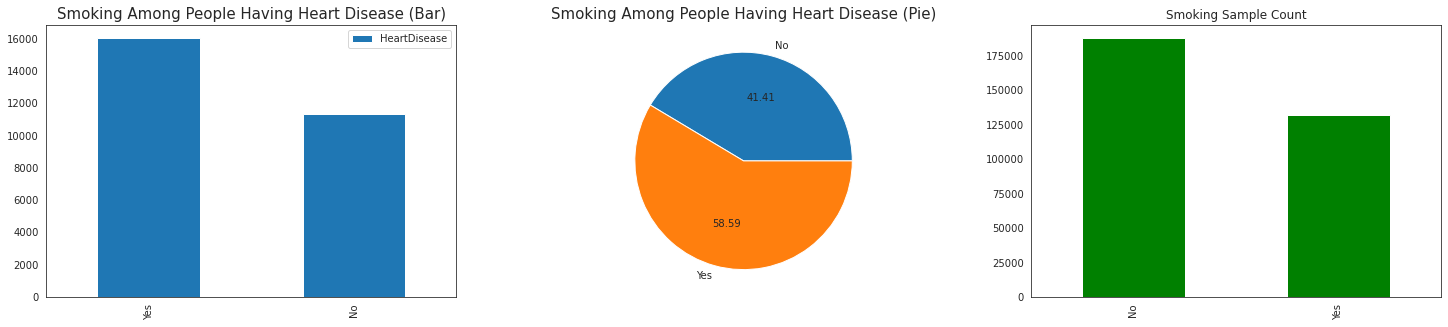

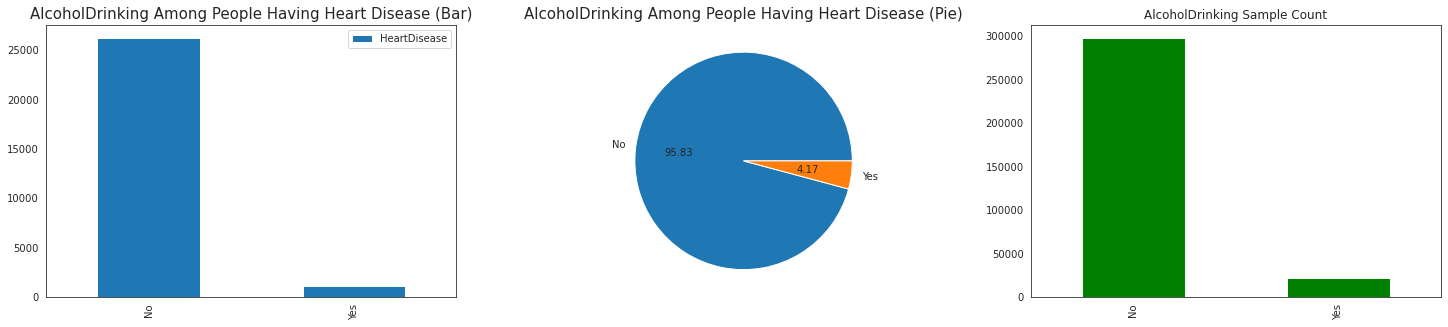

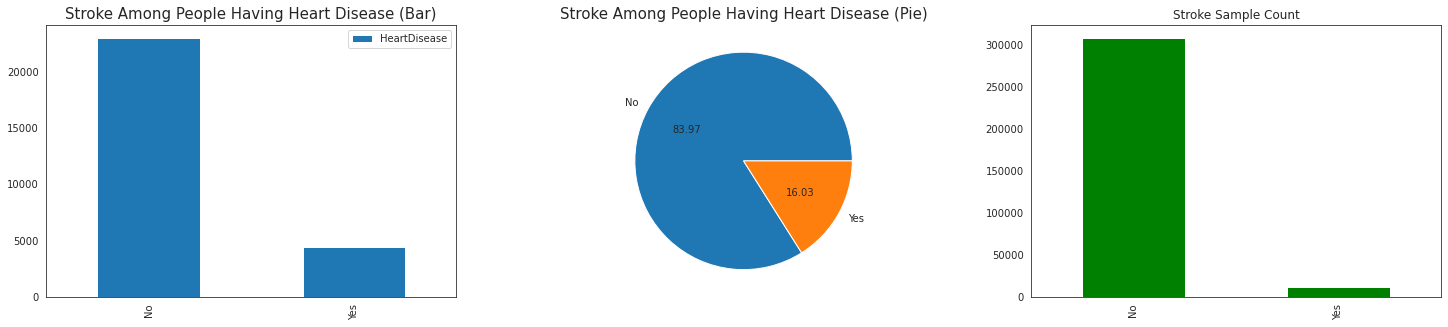

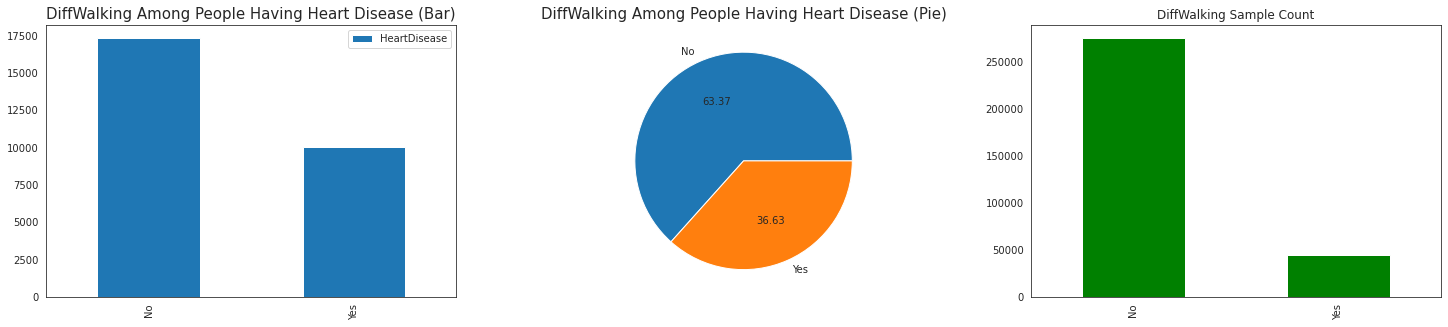

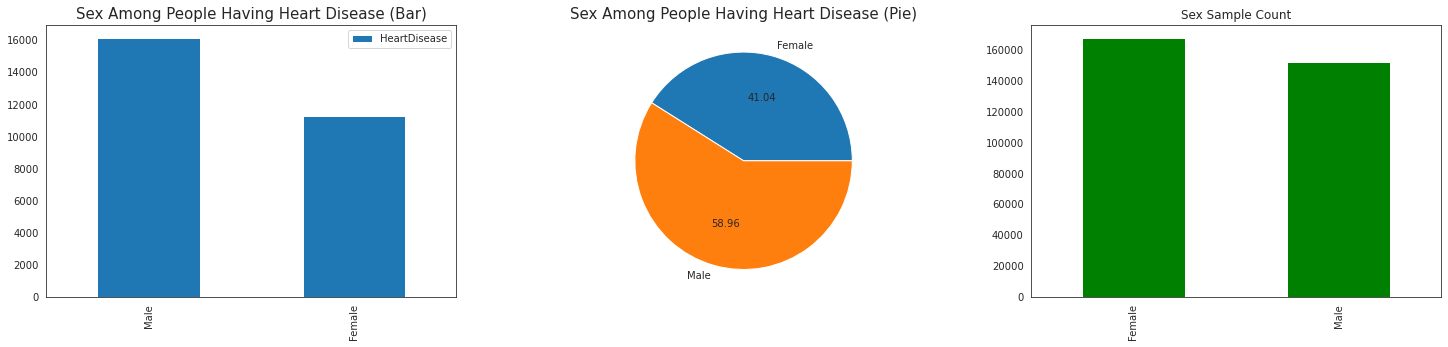

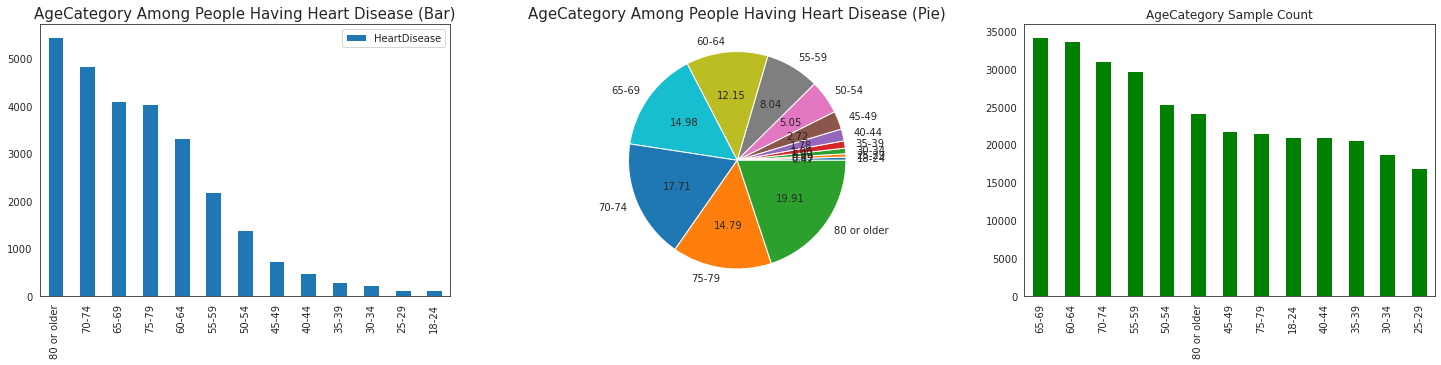

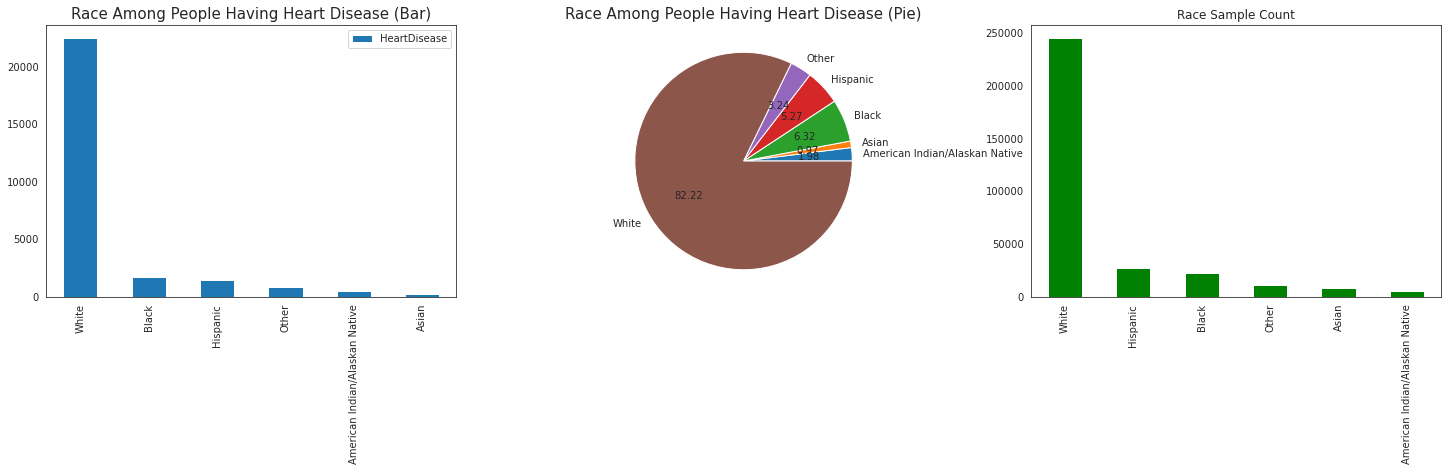

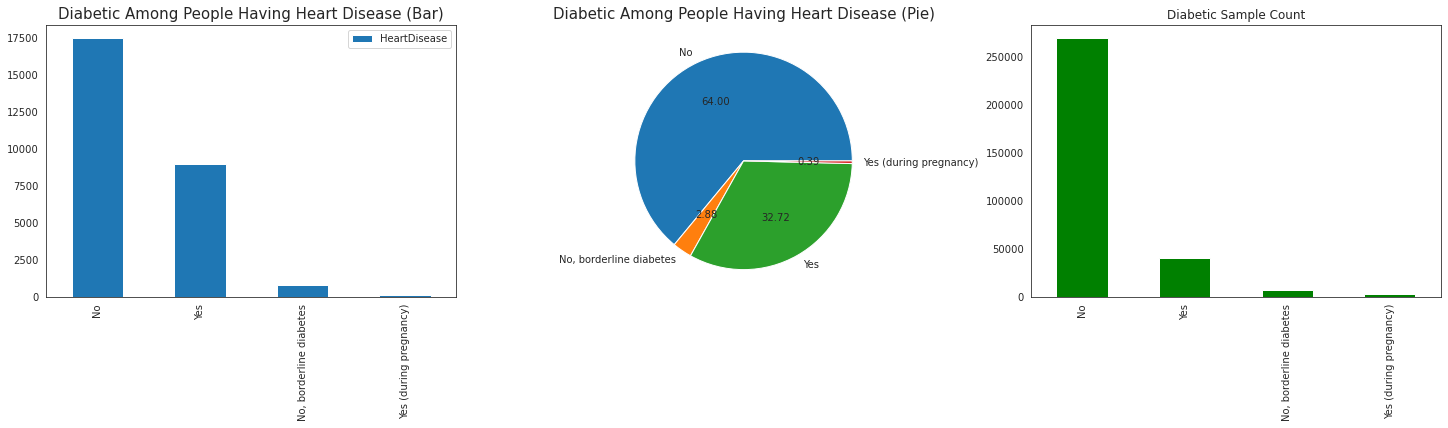

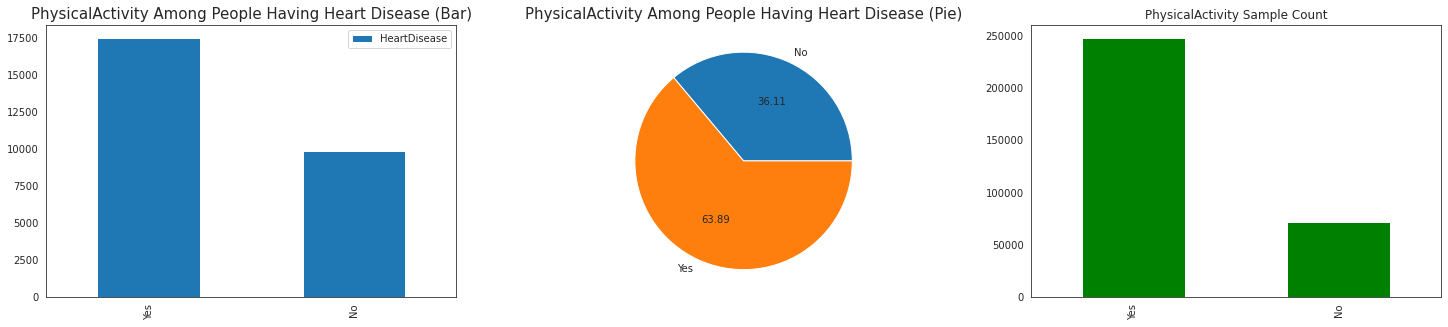

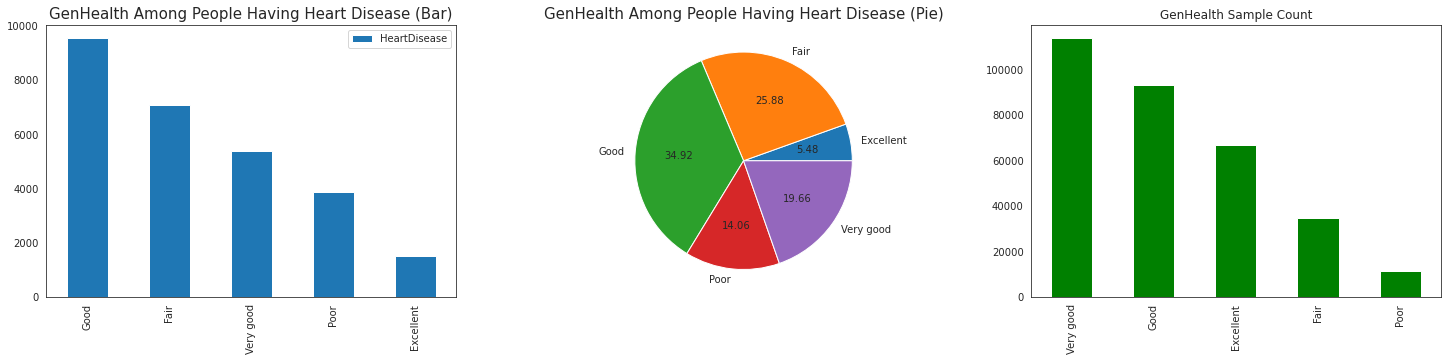

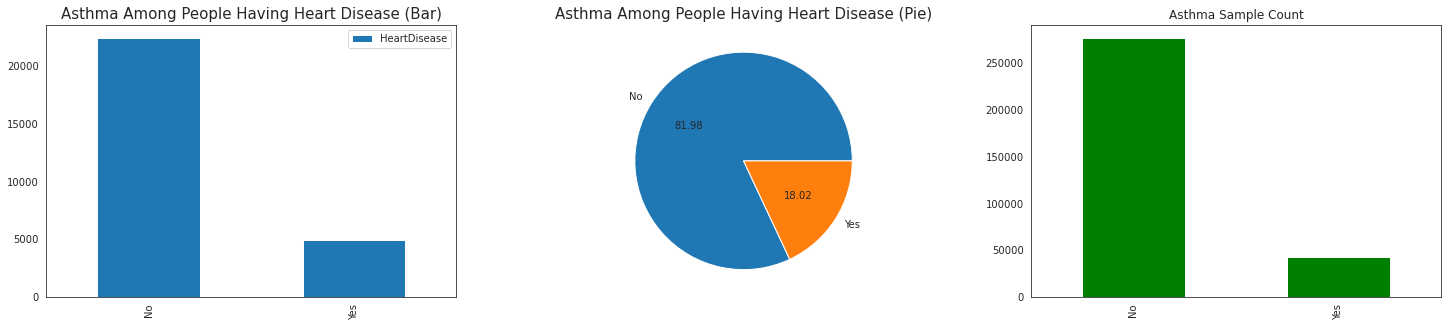

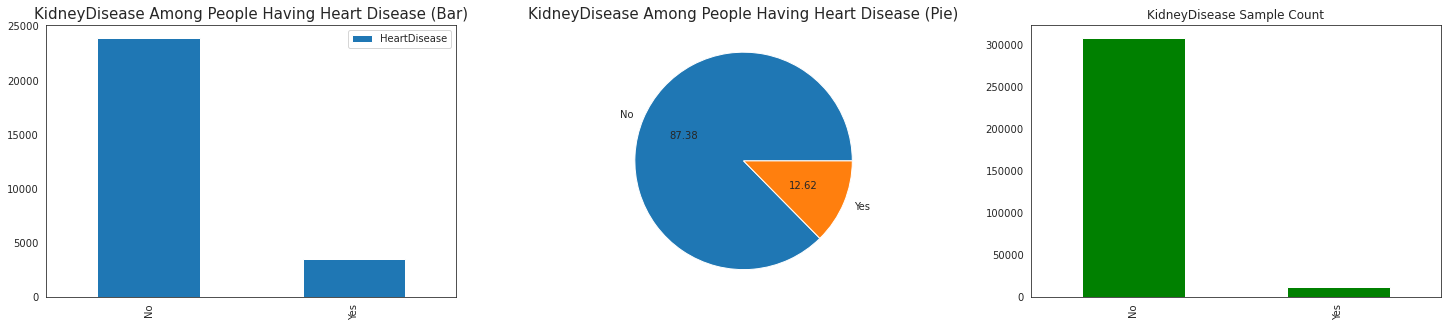

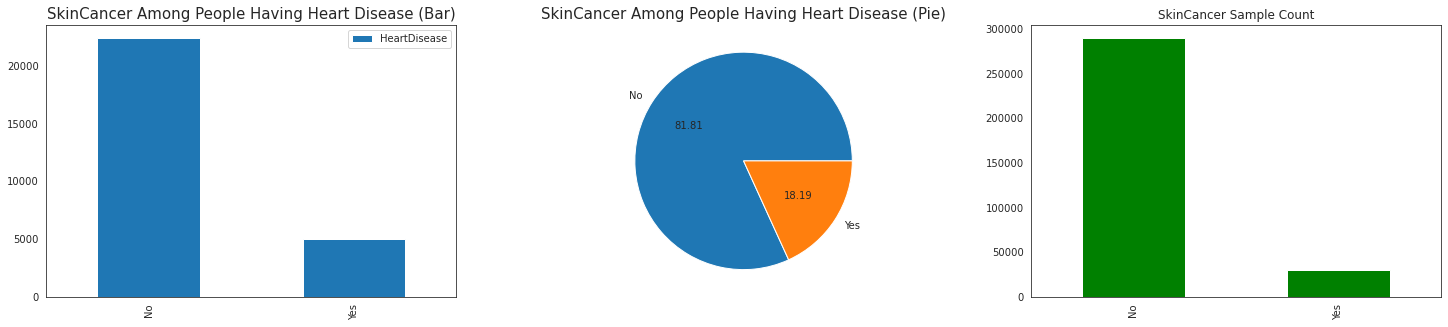

In [40]:
def plotting_function(feature):
    fig, axes = plt.subplots(ncols = 3,figsize = (25,5))
    heart_disease_by_feature = pd.DataFrame(data[data["HeartDisease"] == "Yes"].groupby(feature).count()["HeartDisease"])
    heart_disease_by_feature.sort_values(by = "HeartDisease", ascending = False).plot(kind ="bar", ax = axes[0])
    axes[1].pie(heart_disease_by_feature["HeartDisease"], labels = heart_disease_by_feature.index, autopct = "%.2f")
    data[feature].value_counts().sort_values(ascending = False).plot(kind = "bar", ax = axes[2], color = "green")
    axes[0].set_title(f"{feature} Among People Having Heart Disease (Bar)", size = 15)
    axes[1].set_title(f"{feature} Among People Having Heart Disease (Pie)", size = 15)
    axes[2].set_title(f"{feature} Sample Count")
    axes[0].set_xlabel("")
    axes[2].set_xlabel("")
    axes[2].set_ylabel("")
    plt.show()

for categoric_col in categorical_features[:-1]:
    plotting_function(categoric_col)

## 4.1 Conclusions<a id="section_4_1"></a>

## Work Conclusions:

- During experimenatation even RandomForest could survive with unscaled data, considering other models performance, we scaled the data in each trial.

- Due to heavy computation, we used a smaller dataset to compare the performances and preprocessing methods.

- To measure the performance of the models and preprocessing methods, we used precision, recall and f1 scores besides accuracy score.

- We used bootstrap method to be more confident about the model performances.

- Many of the code (like precision, recall, accuracy scores) we used, can be found in different python libraries.

## Dataset Conclusions:

- Men suffer more from heart disease than women.
- Smoking is bad for heart health.
- As age gets bigger, the risk of heart disease increases.
- From the first and second graphs, physical activity, walking difficulty, alcohol consumption, skin cancer, kidney disease, asthma, diabetics, and stroke seem to have an inverse relationship with heart disease. However, from the third graph, we understand that the reason behind this is the unbalanced distribution of the features.

## 4.2 KNN  Analysis<a id="section_4_2"></a>

##  F1 Score

\begin{aligned}
&F_{1}=2 \cdot \frac{\text { precision } \cdot \text { recall }}{\text { precision }+\text { recall }} \\
&F_{1}=2 \cdot \frac{\text { precision } \cdot \text { recall }}{\text { precision }+\text { recall }}
\end{aligned}

F1 Score also known as balanced f score, is defined as the harmonic average of accuracy rate and recall rate.

In [41]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix , classification_report
from sklearn import metrics
cls = KNeighborsClassifier(n_neighbors=5)
cls.fit(X_train,Y_train)
prediction = cls.predict((X_test))
print('Mean Square Error testing model 1 ', metrics.mean_squared_error(Y_test, prediction))
print("Classification Report: \n", classification_report(Y_test, prediction))

NameError: name 'X_train' is not defined

Mean Square Error testing model 1  0.1092027019225218

Classification Report: 

               precision    recall  f1-score   support

           0       0.99      0.79      0.88     51963
           1       0.83      0.99      0.90     51963

    accuracy                           0.89    103926

## 4.3 Random Forest Analysis<a id="section_4_3"></a>

We know that in the process of building the decision tree, we can get different decision trees by dividing the data with different characteristics. Moreover, different decision tree generation algorithms give priority to the features that can make the purity of the divided data set higher as the division standard. Therefore, through the generated decision tree, we can indirectly obtain the importance of the features in the data set. Therefore, this method is also directly provided in the random forest (decision tree) implemented by sklearn to obtain the importance ranking of features.

In [42]:
from sklearn.model_selection import GridSearchCV
import time
t1 = time.time()

parameters = {  
    'n_estimators': [23,24,25,26],   
    'max_features': ('sqrt','log2','auto'), 
    'max_depth':    (9,10,11,12),     
    'criterion'   : ['gini', 'entropy'],
}
model = RandomForestClassifier()
gridsearch = GridSearchCV(estimator = model,     
                          param_grid = parameters, 
                          cv = 2,
                          n_jobs = -1,
                          return_train_score = False,
                          scoring = "accuracy"      
                         )
gridsearch.fit(X_train, y_train)

t2 = time.time()

print('Best params: {}'.format(gridsearch.best_params_)) 
print('Best Score: {}'.format(gridsearch.best_score_))
print((t2-t1)/60)

NameError: name 'X_train' is not defined